## Preparations

In [158]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

In [159]:
df = pd.read_csv('datasets/taxi.csv', parse_dates= True)

In [160]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [161]:
df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates= True)

In [162]:
df = df.resample('H').sum()

Text(0.5, 1.0, 'Number of orders per hour')

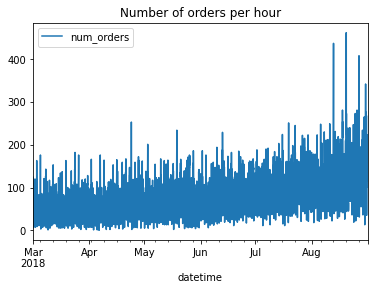

In [163]:
fig, axes = plt.subplots(facecolor='white')

df.plot(ax=axes).set_title('Number of orders per hour')

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Results**

1. Data was loaded and resampled to 1H increments
2. There is an observable trend but not very distinct

## Analysis

Text(0.5, 1.0, 'First difference of number of orders per hour')

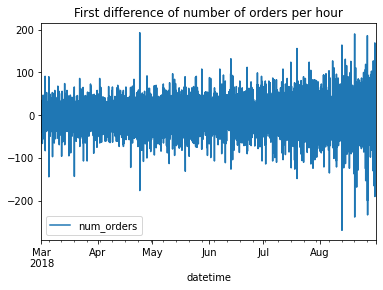

In [165]:
fig, axes = plt.subplots(facecolor='white')

(df-df.shift()).plot(ax=axes).set_title('First difference of number of orders per hour')

First level differences transforms series into a stationary one

In [166]:
x = df['num_orders'].values
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [167]:
x = (df['num_orders']-df['num_orders'].shift()).dropna().values
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.793234
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [168]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize, facecolor='white')
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

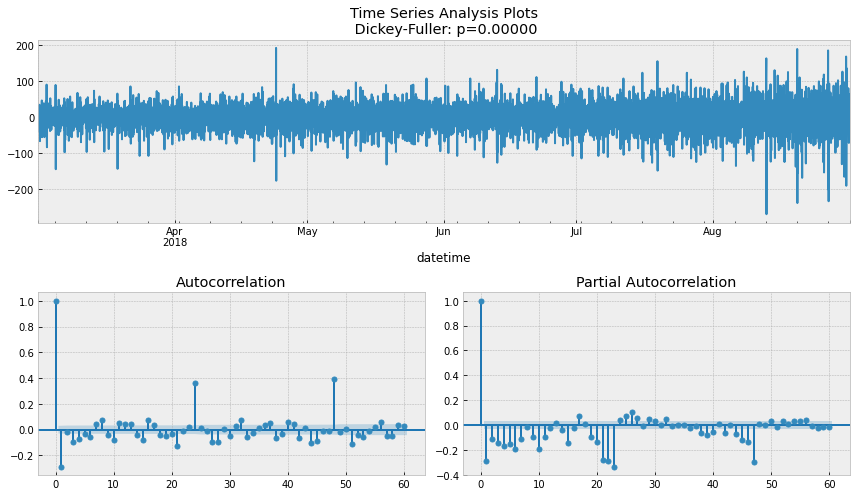

In [169]:
tsplot((df['num_orders']-df['num_orders'].shift()).dropna(), lags=60)

In [170]:
for x in range(1,11):
    df['shift_{}'.format(x)] = df['num_orders'].shift(x)

In [171]:
for x in range(2,9):
    df['ma_{}'.format(x)] = df['num_orders'].shift().rolling(x).mean()

In [172]:
#df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

Text(0.5, 1.0, 'Average orders per day')

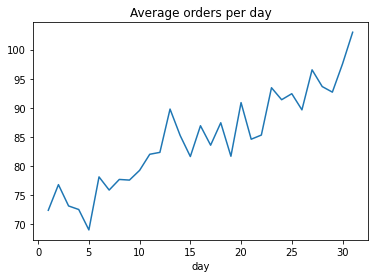

In [173]:
fig, axes = plt.subplots(facecolor='white')

x = df.groupby(by='day')['num_orders'].sum() / df.groupby(by='day')['day'].count()
x.plot(ax=axes).set_title('Average orders per day')

Text(0.5, 1.0, 'Average orders per day of the week')

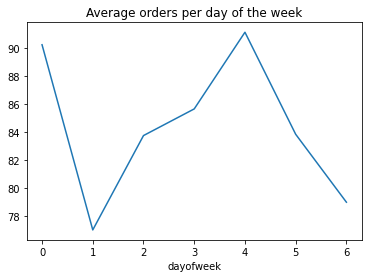

In [174]:
fig, axes = plt.subplots(facecolor='white')

x = df.groupby(by='dayofweek')['num_orders'].sum() / df.groupby(by='dayofweek')['dayofweek'].count()
x.plot(ax=axes).set_title('Average orders per day of the week')

Text(0.5, 1.0, 'Seasonal decomposition of rides')

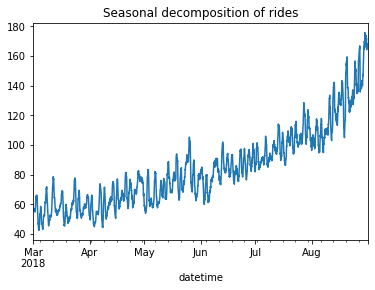

In [175]:
fig, axes = plt.subplots(facecolor='white')

decomposed = seasonal_decompose(df['num_orders'])
decomposed.trend['2018-03-01':'2018-08-31'].plot(ax=axes).set_title('Seasonal decomposition of rides')

Text(0.5, 1.0, 'Residuals from seasonal decomposition of rides')

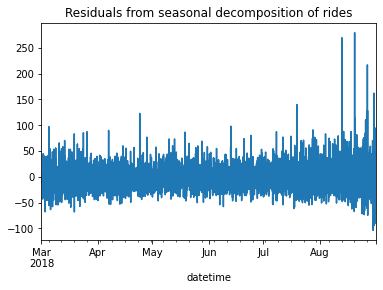

In [176]:
fig, axes = plt.subplots(facecolor='white')

decomposed.resid['2018-03-01':'2018-08-31'].plot(ax=axes).set_title('Residuals from seasonal decomposition of rides')

Text(0.5, 1.0, 'Quantity of rides per day')

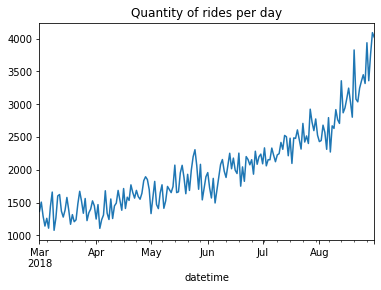

In [177]:
fig, axes = plt.subplots(facecolor='white')

df['num_orders'].resample('D').sum().plot(ax=axes).set_title('Quantity of rides per day')

Text(0.5, 1.0, 'Quantity of rides per month')

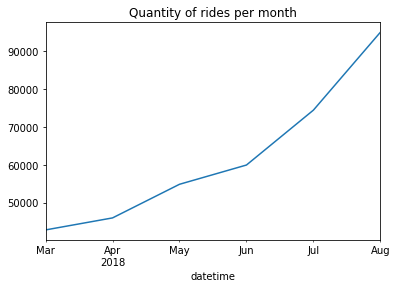

In [178]:
fig, axes = plt.subplots(facecolor='white')

df['num_orders'].resample('M').sum().plot(ax=axes).set_title('Quantity of rides per month')

In [179]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)
train_withna_size = train.shape[0]

In [180]:
train = train.dropna()

In [181]:
train_f = train.drop('num_orders', axis=1)
train_t = train['num_orders']
test_f = test.drop('num_orders', axis=1)
test_t = test['num_orders']

**Results**

1. Created test and train subsamples
2. Added 10 lagged variables + 7 MA + day of the month, month and day of the week (variable for year is useless here)
3. Explored the trend in data - series become stationary at the first difference

## Modeling

I decided to try 3 models. We can add boosting if necessary, but ARIMA model gave required results


### Linear regression

In [182]:
def rmse(pred, fact):
    return mean_squared_error(pred, fact)**0.5

In [183]:
model_l=LinearRegression()
model_l.fit(train_f, train_t)
train_pred_l = model_l.predict(train_f)
test_pred_l = model_l.predict(test_f)
print("rmse train:", rmse(train_pred_l, train_t))
print("rmse test: ", rmse(test_pred_l, test_t))

rmse train: 31.262167116948515
rmse test:  54.48818959325917


### Random forrest

In [184]:
model_f=RandomForestRegressor(n_estimators = 10, random_state=12345)
model_f.fit(train_f, train_t)
train_pred_f = model_f.predict(train_f)
test_pred_f = model_f.predict(test_f)
print("rmse train:", rmse(train_pred_f, train_t))
print("rmse test: ", rmse(test_pred_f, test_t))

rmse train: 12.253066195064223
rmse test:  59.07478981642849


### Arima

We can use grid search to find better parameters, but thanks to prelimenary analysis we have good results at first try

In [185]:
model_arima=sm.tsa.statespace.SARIMAX(df['num_orders'], order=(24, 1, 10)).fit(disp=-1)

Made forecast for the whole period. We need to take into account that predicitons for the first obervations will not be accurate due to the spesifics of the model

In [186]:
forecast = model_arima.predict(start = 0, end = df.shape[0])

In [187]:
train.shape[0]+test.shape[0]

4406

In [188]:
df_1 = pd.DataFrame()
df_1['fact'] = df['num_orders'].copy()
df_1['forecast'] = forecast.to_frame()

In [189]:
df_1

,fact,forecast
datetime,,
2018-03-01 00:00:00,124,0.000000
2018-03-01 01:00:00,85,123.941784
2018-03-01 02:00:00,71,96.473077
2018-03-01 03:00:00,66,78.944180
2018-03-01 04:00:00,43,74.562159
...,...,...
2018-08-31 19:00:00,136,133.552674
2018-08-31 20:00:00,154,157.997176
2018-08-31 21:00:00,159,176.327978


**Results**

Models was calculated, predictions were made

## Testing models

In [190]:
print('Linear regression')
print("rmse train:", rmse(train_pred_l, train_t))
print("rmse test: ", rmse(test_pred_l, test_t))
print('Random forest')
print("rmse train:", rmse(train_pred_f, train_t))
print("rmse test: ", rmse(test_pred_f, test_t))
print('ARIMA model')
print("rmse train:", rmse(df_1.iloc[train_withna_size-train.shape[0]:train.shape[0]]['forecast'], 
                                      df_1.iloc[train_withna_size-train.shape[0]:train.shape[0]]['fact']))
print("rmse test: ", rmse(df_1.iloc[train_withna_size:]['forecast'], 
                                      df_1.iloc[train_withna_size:]['fact']))

Linear regression
rmse train: 31.262167116948515
rmse test:  54.48818959325917
Random forest
rmse train: 12.253066195064223
rmse test:  59.07478981642849
ARIMA model
rmse train: 25.18246396987145
rmse test:  42.3750142122168


**Results**

Arima has a better RMSE on test subsample. Random forest and linear regression seem to have overfitting problem

In [191]:
week_first = df_1['2018-08-14':'2018-08-21' ]
week_last = df_1['2018-08-24': ]
print("rmse for the 1st week of test:", rmse(week_first['forecast'], 
                                      week_first['fact']))
print("rmse for the 2nd week of test: ", rmse(week_last['forecast'], 
                                      week_last['fact']))

rmse for the 1st week of test: 41.20268159047151
rmse for the 2nd week of test:  45.92665980765544


Text(0.5, 1.0, 'Differences between forecast and fact on 1st week')

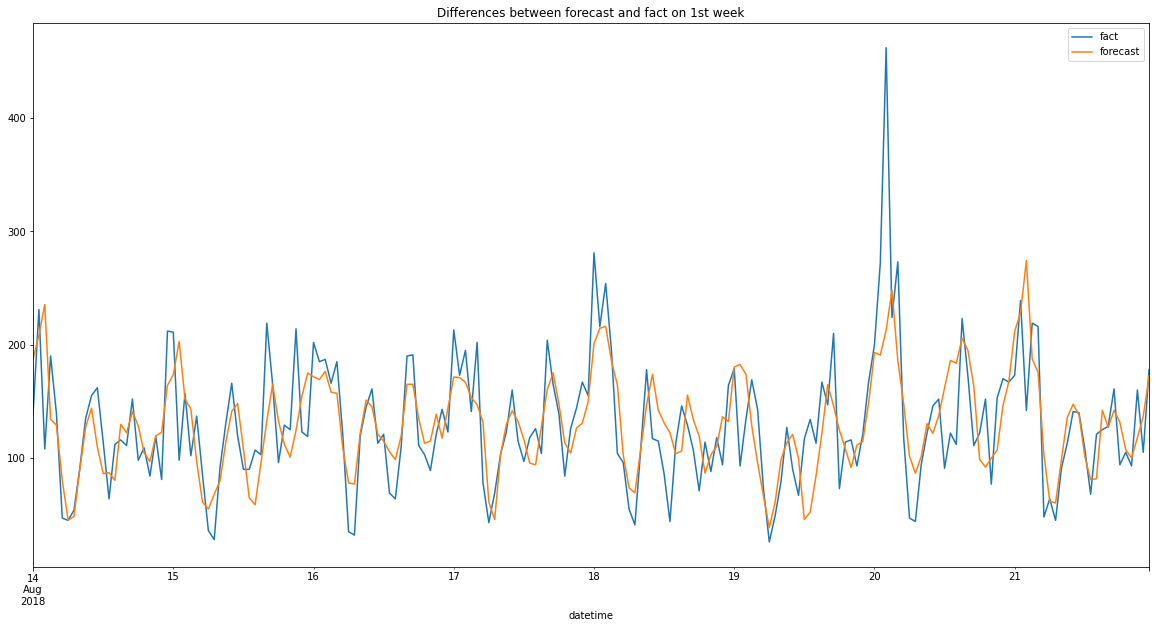

In [192]:
fig, axes = plt.subplots(facecolor='white')

week_first.plot(figsize=(20,10), ax=axes).set_title('Differences between forecast and fact on 1st week')

Text(0.5, 1.0, 'Differences between forecast and fact on the last week')

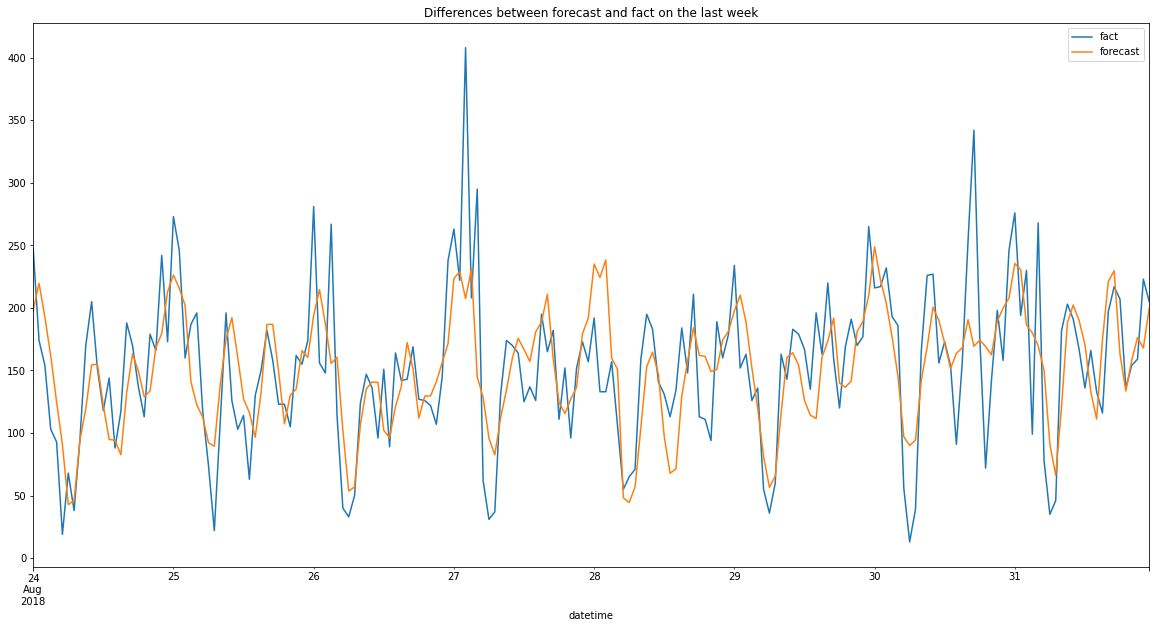

In [193]:
fig, axes = plt.subplots(facecolor='white')

week_last.plot(figsize=(20,10), ax=axes).set_title('Differences between forecast and fact on the last week')

## Conclusions

1. Data was loaded and resampled to 1H increments
2. There is an observable trend but not very distinct. Additional analysis identified a trend that in data. Series become stationary at the first difference
3. Bsed on analysis of autocorrelation created 10 lagged variables + 7 MA. Analysing different potenrtial trend I identified several potential variables: day of the month, month and day of the week (variable for year is useless here)
4. Checked 3 models: linear regression, random tree and ARIMA. The ARIMA models has best RMSE
5. I made a prediction based on ARIMA model and predictions for the first and last week of the test subsample were compared to the actual data. There is a certain increase in RMSE in the last week compared to the first one